# IMDB Movie Review Sentiment Analysis

GitHub: https://github.com/Dimi20cen/MSDS-5511-final-Movie-Review-Sentiment-Analysis

This notebook walks through the process of analyzing IMDb movie reviews to classify their sentiment (positive or negative). We'll start by exploring the data, then build a baseline CNN model, and finally fine-tune a more powerful DistilBERT model.

**Steps:**
1.  **Data Gathering & Prep:** Load the IMDb dataset, understand its structure, and clean the text.
2.  **Deep Learning Problem:** The goal is binary sentiment classification (positive/negative).
3.  **Exploratory Data Analysis (EDA):** Inspect, visualize, and clean the data. (Phase 1)
4.  **Deep Learning Analysis:** Build, train, and evaluate a 1D CNN and a DistilBERT model.

In [2]:
# --- Imports and Initial Setup ---
import os
import random
import re
import warnings
from collections import Counter

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding,
    set_seed
)
import evaluate # Hugging Face evaluate library for metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
set_seed(SEED)

# Download stopwords
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))
print(f"{len(stop_words)} English stopwords loaded.")
print("Imports and initial setup finito.")

2025-04-29 18:34:28.812585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745951669.003757      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745951669.060955      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


198 English stopwords loaded.
Imports and initial setup finito.


## Setup and Data Exploration (EDA)

First things first, let's import all the libraries we'll need and set things up for reproducible results. We'll also grab the NLTK stopwords list to help clean up our text data later.

In [3]:
# Load the IMDB dataset from Hugging Face
imdb_dataset = load_dataset('imdb')
print("Dataset loaded successfully.")

print("\nDataset structure:")
print(imdb_dataset)

# Access train and test splits
train_data = imdb_dataset['train']
test_data = imdb_dataset['test']

print(f"\nNumber of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

# View sample reviews and labels
print("\nSample Training Review:")
sample_idx = random.randint(0, len(train_data) - 1)
sample_text = train_data[sample_idx]['text']
sample_label = train_data[sample_idx]['label']
print(f"Review Text:\n{sample_text}")
print(f"Label: {'Positive' if sample_label == 1 else 'Negative'} (raw: {sample_label})")


# Check class balance in training data
train_labels = train_data['label']
train_label_counts = Counter(train_labels)
print("\nTraining set class balance:")
print(f"Negative (0): {train_label_counts[0]}")
print(f"Positive (1): {train_label_counts[1]}")

# Check class balance in test data
test_labels = test_data['label']
test_label_counts = Counter(test_labels)
print("\nTest set class balance:")
print(f"Negative (0): {test_label_counts[0]}")
print(f"Positive (1): {test_label_counts[1]}")

# Convert Hugging Face Datasets to Pandas DataFrames for easier EDA
train_df = train_data.to_pandas()
test_df = test_data.to_pandas()

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded successfully.

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Number of training samples: 25000
Number of test samples: 25000

Sample Training Review:
Review Text:
Arguably this is a very good "sequel", better than the first live action film 101 Dalmatians. It has good dogs, good actors, good jokes and all right slapstick! <br /><br />Cruella DeVil, who has had some rather major therapy, is now a lover of dogs and very kind to them. Many, including Chloe Simon, owner of one of the dogs that Cruella once tried to kill, do not believe this. Others, like Kevin Shepherd (owner of 2nd Chance Dog Shelter) believe that she has changed. <br /><br />Meanwhile, Dipstick, with his mate, have given birth to three cute dalmat

## Text Cleanup

Movie reviews scraped from the web often contain HTML tags (like `<br />` for line breaks). These aren't useful for our analysis, so I'll write a simple function to remove them and also convert everything to lowercase to treat "Movie" and "movie" as the same word.

In [4]:
# Text Cleaning Strategy

def clean_text(text):
    """
    Basic text cleaning:
    - Remove HTML tags
    - Convert to lowercase
    """
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning 
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
# Find the cleaned version of the specific sample shown earlier
cleaned_sample_text = clean_text(sample_text)
print("Sample cleaned text (from earlier sample):")
print(cleaned_sample_text)


Sample cleaned text (from earlier sample):
arguably this is a very good "sequel", better than the first live action film 101 dalmatians. it has good dogs, good actors, good jokes and all right slapstick! cruella devil, who has had some rather major therapy, is now a lover of dogs and very kind to them. many, including chloe simon, owner of one of the dogs that cruella once tried to kill, do not believe this. others, like kevin shepherd (owner of 2nd chance dog shelter) believe that she has changed. meanwhile, dipstick, with his mate, have given birth to three cute dalmatian puppies! little dipper, domino and oddball... starring eric idle as waddlesworth (the hilarious macaw), glenn close as cruella herself and gerard depardieu as le pelt (another baddie, the name should give a clue), this is a good family film with excitement and lots more!! one downfall of this film is that is has a lot of painful slapstick, but not quite as excessive as the last film. this is also funnier than the la

## Exploring the Data (EDA)

Now we explore the cleaned text data. We'll look at:

* **Review Lengths:** How long are these reviews typically? Are positive reviews longer or shorter than negative ones? This helps us decide how much text to feed into our models later.
* **Word Frequencies:** What are the most common words used overall? Are there different common words in positive vs. negative reviews? (We'll ignore common "stopwords" like 'the', 'is', 'a').


Review Length Statistics (Word Count):
count    25000.00000
mean       231.48264
std        171.98452
min         10.00000
25%        126.00000
50%        173.00000
75%        281.00000
max       2459.00000
Name: word_count, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


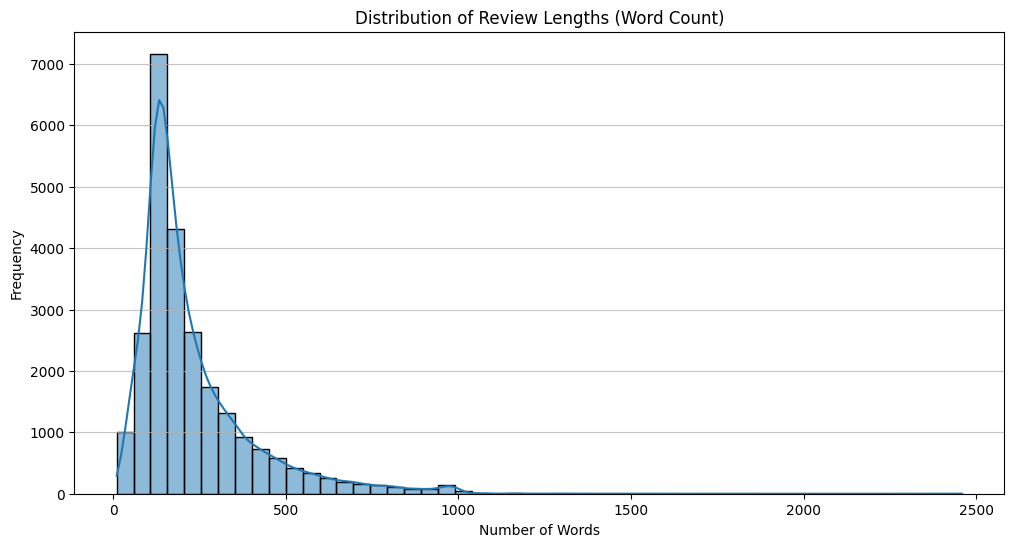

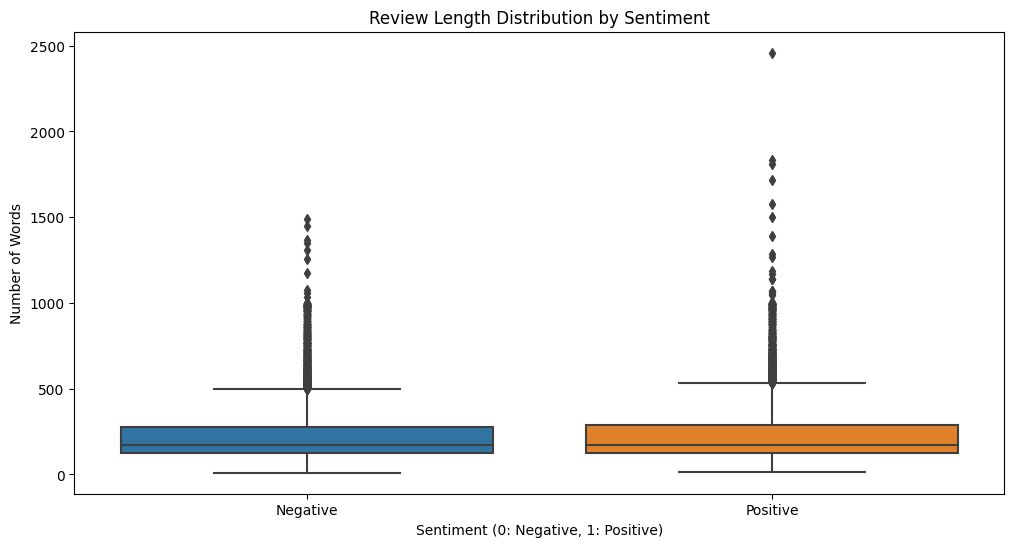

Calculating word frequencies for 25000 reviews...
Word frequencies calculated.

Top 25 Most Common Words (excluding stopwords):
[('movie', 30916), ('film', 27804), ('one', 22876), ('like', 18872), ('even', 12210), ('would', 12042), ('good', 11983), ('really', 11084), ('see', 10459), ('get', 8976), ('much', 8787), ('story', 8764), ('first', 8134), ('also', 8112), ('time', 7954), ('great', 7767), ('people', 7710), ('make', 7599), ('could', 7599), ('made', 7051), ('bad', 6844), ('think', 6792), ('many', 6452), ('it.', 6401), ('never', 6341)]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


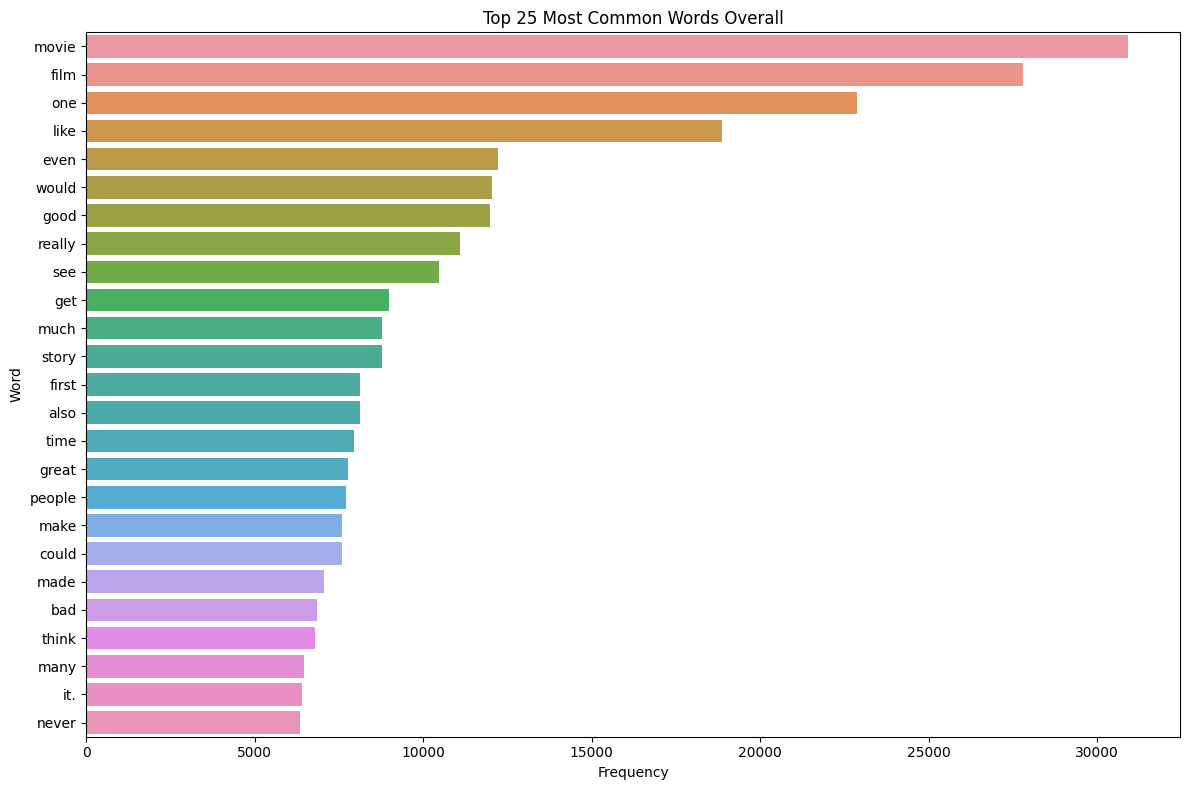

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


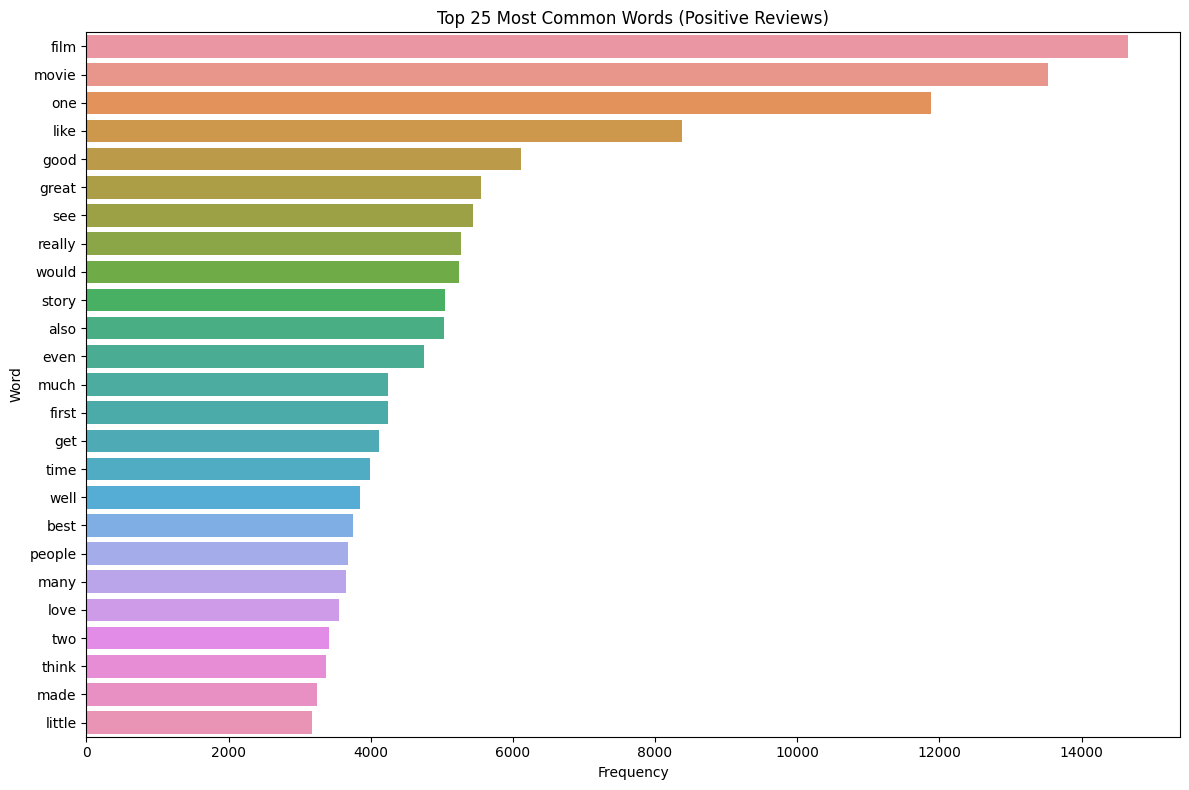

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


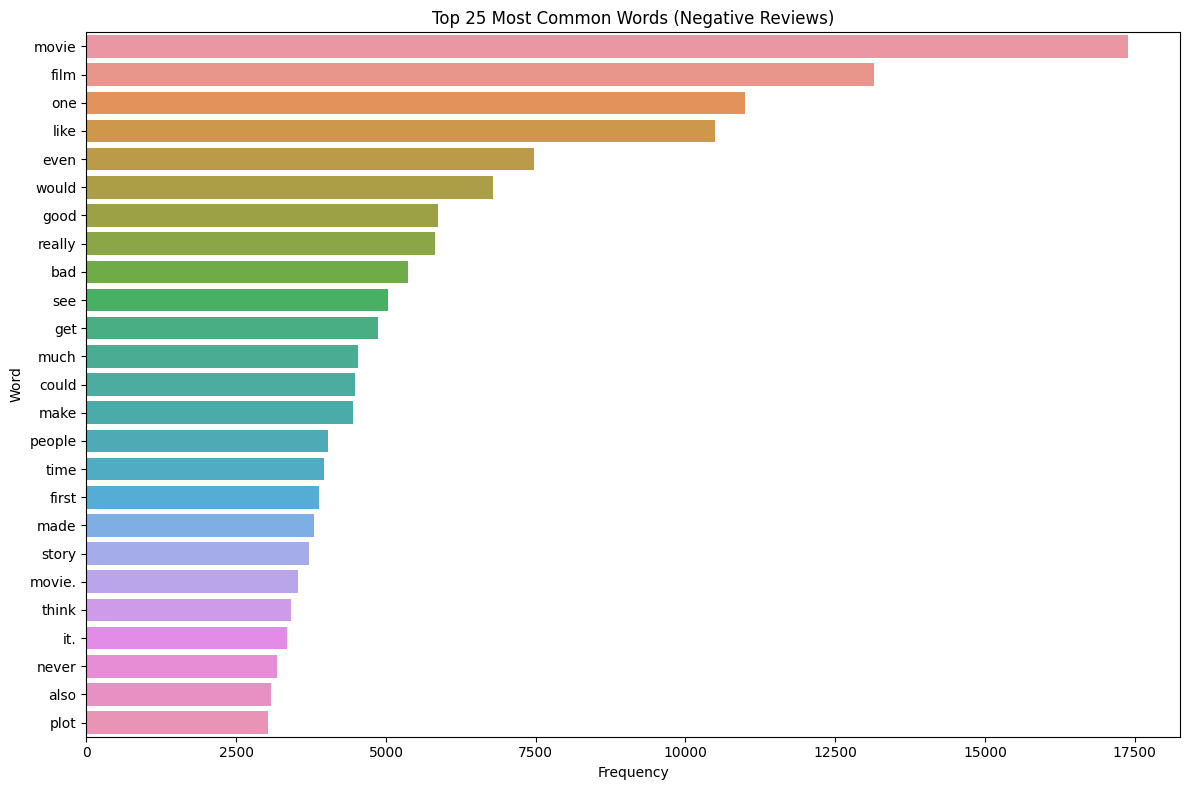

In [5]:
text_column = 'cleaned_text' if train_df is not None and 'cleaned_text' in train_df.columns else 'text'
apply_cleaning_on_fly = text_column == 'text'

# --- Review Length Analysis ---

# Calculate word count by splitting the text and counting the words
train_df['word_count'] = train_df[text_column].apply(lambda x: len(x.split()))



# Descriptive statistics for word count
print("\nReview Length Statistics (Word Count):")
print(train_df['word_count'].describe())

# Plot distribution of review lengths, histogram
plt.figure(figsize=(12, 6))
sns.histplot(train_df['word_count'], bins=50, kde=True)
plt.title('Distribution of Review Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot distribution by sentiment, box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='word_count', data=train_df)
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Number of Words')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()



# --- Word Frequency Analysis ---

SAMPLE_SIZE_FREQ = len(train_data)

word_freq = Counter()
positive_word_freq = Counter()
negative_word_freq = Counter()

print(f"Calculating word frequencies for {SAMPLE_SIZE_FREQ} reviews...")

# Determine the iterator based on whether DataFrame conversion was successful
data_iterator = train_df.iterrows()

for i, data_item in data_iterator:
    # Accessing DataFrame row via iterrows()
    row = data_item
    text = row[text_column]
    label = row['label']


    # Split text into words and filter out stopwords and single characters
    words = text.split()
    words_filtered = [word for word in words if word not in stop_words and len(word) > 1]

    # Update the counters
    word_freq.update(words_filtered)
    if label == 1: # Positive review
        positive_word_freq.update(words_filtered)
    else:
        negative_word_freq.update(words_filtered)

print("Word frequencies calculated.")

# Get the most common words
N_MOST_COMMON = 25
most_common_words = word_freq.most_common(N_MOST_COMMON)
most_common_positive = positive_word_freq.most_common(N_MOST_COMMON)
most_common_negative = negative_word_freq.most_common(N_MOST_COMMON)

print(f"\nTop {N_MOST_COMMON} Most Common Words (excluding stopwords):")
print(most_common_words)

# Visualize top N words, bar plots
def plot_word_freq(word_counts, title):
    """Helper function to plot word frequencies."""
    if not word_counts: # Handle empty list case
        print(f"No words to plot for: {title}")
        return
    words, counts = zip(*word_counts)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

plot_word_freq(most_common_words, f'Top {N_MOST_COMMON} Most Common Words Overall')
plot_word_freq(most_common_positive, f'Top {N_MOST_COMMON} Most Common Words (Positive Reviews)')
plot_word_freq(most_common_negative, f'Top {N_MOST_COMMON} Most Common Words (Negative Reviews)')

## EDA Summary and Next Steps

Recap of what we learned from EDA:
* **Balanced Data:** We have an equal number of positive and negative reviews, which is great for training a fair model.
* **Cleaning:** We removed HTML tags and lowercased the text.
* **Review Length:** Reviews vary a lot in length. Most are under 500-750 words, but some are much longer. Looking at the stats (like the 95th percentile), a maximum length (`maxlen`) of around 500 words seems like a reasonable choice for our models. This captures most of the text in the vast majority of reviews without making our models work with excessively long sequences.
* **Common Words:** We saw the most frequent words overall and how they differ slightly between positive and negative reviews.

## Building a Baseline Model (1D CNN)

We'll start with a 1D Convolutional Neural Network (CNN). CNNs are often used for image analysis, but they can be effective for text as well, by treating sequences of word embeddings like a 1D "image".

Plan for this phase:
1.  **Preprocess for CNN:** Convert text reviews into numbers that the model can understand. This involves:
    * **Tokenization:** Breaking text into words (tokens) and assigning a unique integer ID to each word.
    * **Padding/Truncating:** Making all review sequences the same length (`maxlen` = 500, as decided earlier).
2.  **Split Data:** Separate our training data into a training set and a validation set. We use the validation set during training to check how well the model is learning and to prevent overfitting.
3.  **Define CNN Model:** Build the actual network architecture using Keras (part of TensorFlow). This will involve an Embedding layer, Conv1D layer(s), Pooling, and Dense layers.
4.  **Train the Model:** Feed the training data to the model and let it learn. We'll use callbacks like `EarlyStopping` (to stop training if performance on the validation set doesn't improve) and `ModelCheckpoint` (to save the best version of the model).
5.  **Evaluate:** Test the trained model on the unseen test data to see how well it performs in the real world (or at least, on data it hasn't trained on).
6.  **Analyze:** Look at the results, including accuracy, a confusion matrix (to see what kinds of mistakes it makes), and a classification report (for precision, recall, F1-score).

In [7]:
# --- Configuration ---

MAXLEN = 500
VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

## Preprocessing for the CNN

Here, we take the cleaned text and turn it into sequences of numbers.

* **Tokenizer:** We create a `Tokenizer` object from Keras. We tell it to only care about the top `VOCAB_SIZE` most frequent words. It learns the mapping from words to integers based on the training text. Any word not in its vocabulary will be marked with a special "out-of-vocabulary" (OOV) token.
* **Sequencing:** We convert each review text into a sequence of these integers.
* **Padding:** We make all sequences the same length (`MAXLEN`) by adding zeros at the end (`padding='post'`) or cutting off words from the end (`truncating='post'`).

In [8]:
# --- Preprocessing for CNN ---

# Extract cleaned text and labels from the DataFrames
X_train_text = train_df['cleaned_text'].values
y_train = train_df['label'].values
X_test_text = test_df['cleaned_text'].values
y_test = test_df['label'].values

# Tokenization
print(f"Tokenizing text (using top {VOCAB_SIZE} words)...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)

# Convert text to sequences of integers
print("Converting text to sequences...")
X_train_sequences = tokenizer.texts_to_sequences(X_train_text)
X_test_sequences = tokenizer.texts_to_sequences(X_test_text)

# Get the actual vocabulary size found by the tokenizer
word_index = tokenizer.word_index
actual_vocab_size = len(word_index) + 1
print(f"Actual vocabulary size found: {len(word_index)}")
print(f"Effective vocabulary size (input_dim for Embedding): {min(VOCAB_SIZE, actual_vocab_size)}")


# Padding / Truncation
print(f"Padding/Truncating sequences to length {MAXLEN}...")
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAXLEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAXLEN, padding='post', truncating='post')

print(f"Shape of padded training sequences: {X_train_padded.shape}")
print(f"Shape of padded test sequences: {X_test_padded.shape}")

Tokenizing text (using top 20000 words)...
Converting text to sequences...
Actual vocabulary size found: 88070
Effective vocabulary size (input_dim for Embedding): 20000
Padding/Truncating sequences to length 500...
Shape of padded training sequences: (25000, 500)
Shape of padded test sequences: (25000, 500)


## Splitting Data: Training and Validation

We need to set aside a portion of our training data to use as a validation set. The model doesn't train on this validation data, but we use it after each training epoch to see how well the model generalizes to data it hasn't seen before. This helps us tune the model and detect overfitting (when the model learns the training data too well but performs poorly on new data).

In [9]:
# --- Data Splitting ---

# Split the padded training data and corresponding labels
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_padded, y_train,
    test_size=VALIDATION_SPLIT,
    random_state=SEED,
    stratify=y_train           # Keep class balance in splits
)

print(f"Training split shape: {X_train_split.shape}, Labels: {y_train_split.shape}")
print(f"Validation split shape: {X_val_split.shape}, Labels: {y_val_split.shape}")
print(f"Test set shape (kept separate): {X_test_padded.shape}, Labels: {y_test.shape}")

Training split shape: (20000, 500), Labels: (20000,)
Validation split shape: (5000, 500), Labels: (5000,)
Test set shape (kept separate): (25000, 500), Labels: (25000,)


## Defining the 1D CNN Model

Now we define the layers of our neural network using Keras's `Sequential` API.

1.  **Embedding Layer:** This is the crucial first layer. It takes the integer sequences and turns each integer (word ID) into a dense vector of a fixed size (`EMBEDDING_DIM`). These vectors (embeddings) are learned during training and capture semantic relationships between words (e.g., 'good' and 'great' might have similar vectors). `input_dim` is our vocabulary size, and `input_length` is `MAXLEN`.
2.  **Dropout:** Randomly sets a fraction of input units to 0 during training. This helps prevent overfitting by making the network less reliant on specific neurons.
3.  **Conv1D Layer:** This layer applies convolution filters across the sequence of word embeddings. It helps detect local patterns (like n-grams, sequences of words) regardless of their position in the review. `filters` is the number of patterns to learn, and `kernel_size` is the length of the pattern (e.g., 5 words).
4.  **GlobalMaxPooling1D:** Takes the maximum value across the entire sequence dimension for each filter learned by the Conv1D layer. This reduces the dimensionality and helps capture the most important feature detected by each filter anywhere in the review.
5.  **Dense Layer:** A standard fully connected layer.
6.  **Dropout:** Another dropout layer for regularization before the final output.
7.  **Output Dense Layer:** A single neuron with a `sigmoid` activation function. Sigmoid squashes the output to be between 0 and 1, representing the probability of the review being positive.
Finally, we `compile` the model, specifying the `adam` optimizer, `binary_crossentropy` loss function, and tracking `accuracy`.

In [11]:
# --- CNN Model Definition (Keras) ---

# Keras layers
model = Sequential([
    Embedding(input_dim=min(VOCAB_SIZE, actual_vocab_size),
              output_dim=EMBEDDING_DIM, 
              input_length=MAXLEN),

    Dropout(0.2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    # Reduces the dimensionality by taking the max value
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training the CNN

It's time to train! We call `model.fit()`, passing in our training data (`X_train_split`, `y_train_split`) and validation data (`X_val_split`, `y_val_split`).

`callbacks`:
* `EarlyStopping`: Monitors the `val_loss` (loss on the validation set). If it doesn't improve for a set number of epochs (`patience=3`), training stops automatically. `restore_best_weights=True` ensures the model weights are reset to those from the epoch with the best validation loss.
* `ModelCheckpoint`: Also monitors `val_loss` and saves the entire model only when the validation loss improves. This gives us the best performing model saved to disk.

We'll also plot the training and validation accuracy and loss over epochs to visualize the learning process.

Starting training for up to 10 epochs...
Epoch 1/10


I0000 00:00:1745953123.194156     125 service.cc:148] XLA service 0x7b62d00036b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745953123.194701     125 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745953123.577825     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  9/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5186 - loss: 0.6934

I0000 00:00:1745953126.286216     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5748 - loss: 0.6641
Epoch 1: val_loss improved from inf to 0.38006, saving model to ./best_cnn_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5754 - loss: 0.6637 - val_accuracy: 0.8280 - val_loss: 0.3801
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8531 - loss: 0.3481
Epoch 2: val_loss improved from 0.38006 to 0.26297, saving model to ./best_cnn_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8532 - loss: 0.3479 - val_accuracy: 0.8914 - val_loss: 0.2630
Epoch 3/10
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9278 - loss: 0.1998
Epoch 3: val_loss improved from 0.26297 to 0.25230, saving model to ./best_cnn_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9281 - loss: 0.1990 - val_accuracy: 0.9050 - val_loss: 0.2523
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9689 - loss: 0.1020
Epoch 4: val_loss did not improve from 

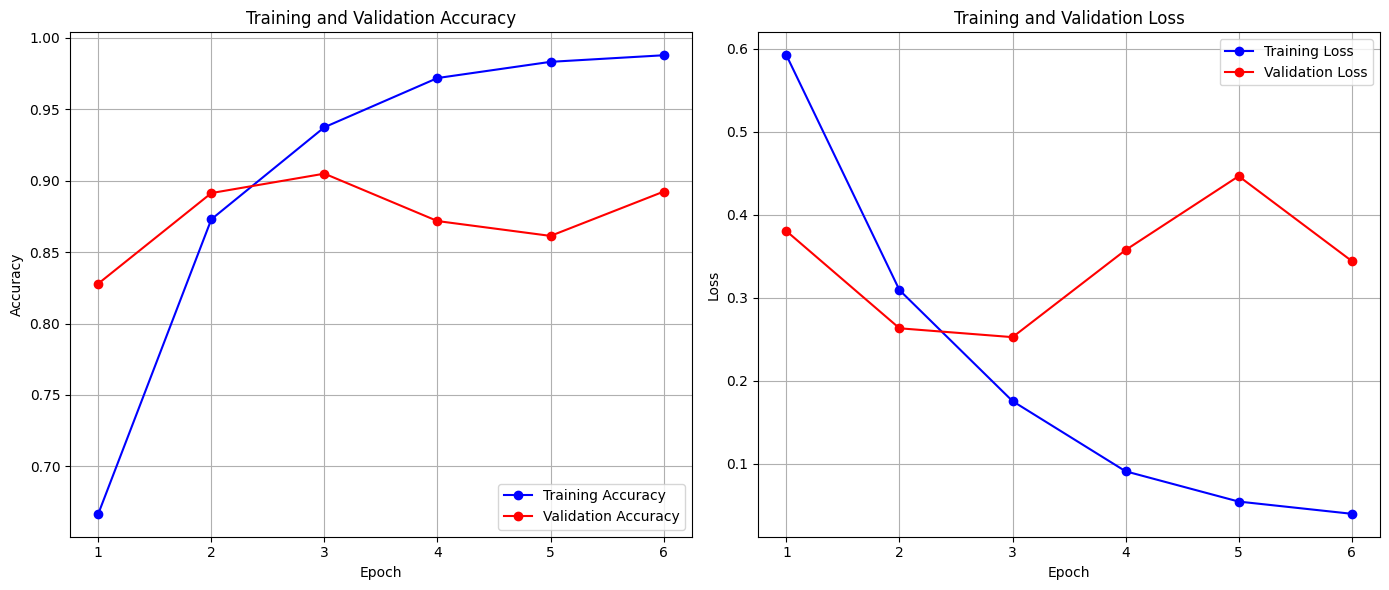

In [12]:
# --- Training ---

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

# ModelCheckpoint: Save the best model based on validation loss
checkpoint_filepath = './best_cnn_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print(f"Starting training for up to {EPOCHS} epochs...")
# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history (accuracy and loss)
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\nPlotting training history...")
plot_training_history(history)

## Evaluating the Baseline Model
We load the best model that was saved by `ModelCheckpoint` (just to be sure we have the one with the lowest validation loss) and evaluate its performance on the `X_test_padded` and `y_test` data, which the model has never seen before. This gives us a realistic measure of how well it generalizes.

Evaluating model on the test set.....

Test Loss: 0.2775
Test Accuracy: 0.8858
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Confusion Matrix:
[[11268  1232]
 [ 1623 10877]]


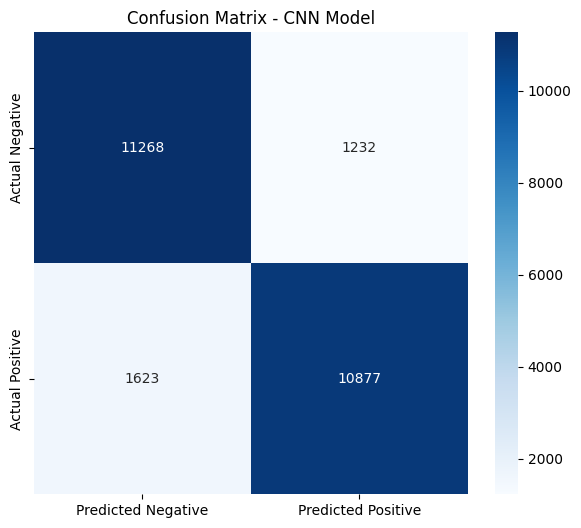


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.89     12500
    Positive       0.90      0.87      0.88     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [14]:
# --- Evaluation ---

# Load the best model saved by ModelCheckpoint
# Load the model saved in .keras format
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Evaluate the loaded best model on the test set
print("Evaluating model on the test set.....")
loss, accuracy = best_model.evaluate(X_test_padded, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Initial CNN Analysis ---

# Generate predictions on the test set
y_pred_prob = best_model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix for better visualization
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - CNN Model')
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

## Trying DistilBERT

We'll use DistilBERT, a smaller, faster version of the BERT model. BERT and its variants (like DistilBERT) are Transformer models that are pre-trained on vast amounts of text data. This pre-training allows them to have a deep understanding of language context. We will *fine-tune* this pre-trained model on our specific IMDB task.

Here's the process using the Hugging Face `transformers` library:
1.  **Load Data (Again):** Reload the dataset using `datasets` to ensure we have it in the right format for the `transformers` library.
2.  **Preprocessing (Tokenizer):** Get the specific tokenizer designed for DistilBERT. This tokenizer splits words and also handles sub-word tokenization (e.g., "running" might become "run" and "**ing") and adds special tokens required by the model.
3.  **Tokenize Dataset:** Apply the tokenizer to our reviews. We'll truncate or pad sequences to the model's maximum length.
4.  **Split Data:** Split the tokenized training set into train/validation splits.
5.  **Load Pre-trained Model:** Load the DistilBERT model architecture with its pre-trained weights, but configure the final layer for our specific task.
6.  **Fine-tuning Setup:**
    * **Data Collator:** Set up a data collator that will handle padding dynamically within each batch. This is more efficient than padding everything to the absolute maximum length beforehand.
    * **Metrics Function:** Define a function to calculate metrics during evaluation. We'll use the `evaluate` library for this.
    * **Training Arguments/Compile:** Configure the training process (like learning rate, number of epochs, batch size) and compile the TensorFlow model with an optimizer and loss. Fine-tuning usually requires a smaller learning rate and fewer epochs than training from scratch.
7.  **Fine-tune:** Train (fine-tune) the model using `model.fit` with the prepared datasets.
8.  **Evaluate:** Evaluate the fine-tuned model on the test set.
9.  **Analyze:** Look at the confusion matrix and classification report for the DistilBERT model, and compare its performance to the CNN baseline.

Tokenizer loaded for distilbert-base-uncased
Tokenizing dataset (this may take a few minutes)...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Dataset splits prepared:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

TF Model loaded for distilbert-base-uncased
Starting fine-tuning using model.fit for 3 epochs...
Epoch 1/3
1250/1250 [==============================] - 726s 562ms/step - loss: 0.2591 - accuracy: 0.8946 - val_loss: 0.2111 - val_accuracy: 0.9178
Epoch 2/3
1250/1250 [==============================] - 697s 557ms/step - loss: 0.1397 - accuracy: 0.9507 - val_loss: 0.2526 - val_accuracy: 0.9176
Epoch 3/3
1250/1250 [==============================] - 696s 557ms/step - loss: 0.0781 - accuracy: 0.9763 - val_loss: 0.3712 - val_accuracy: 0.9088
Fine-tuning finito.


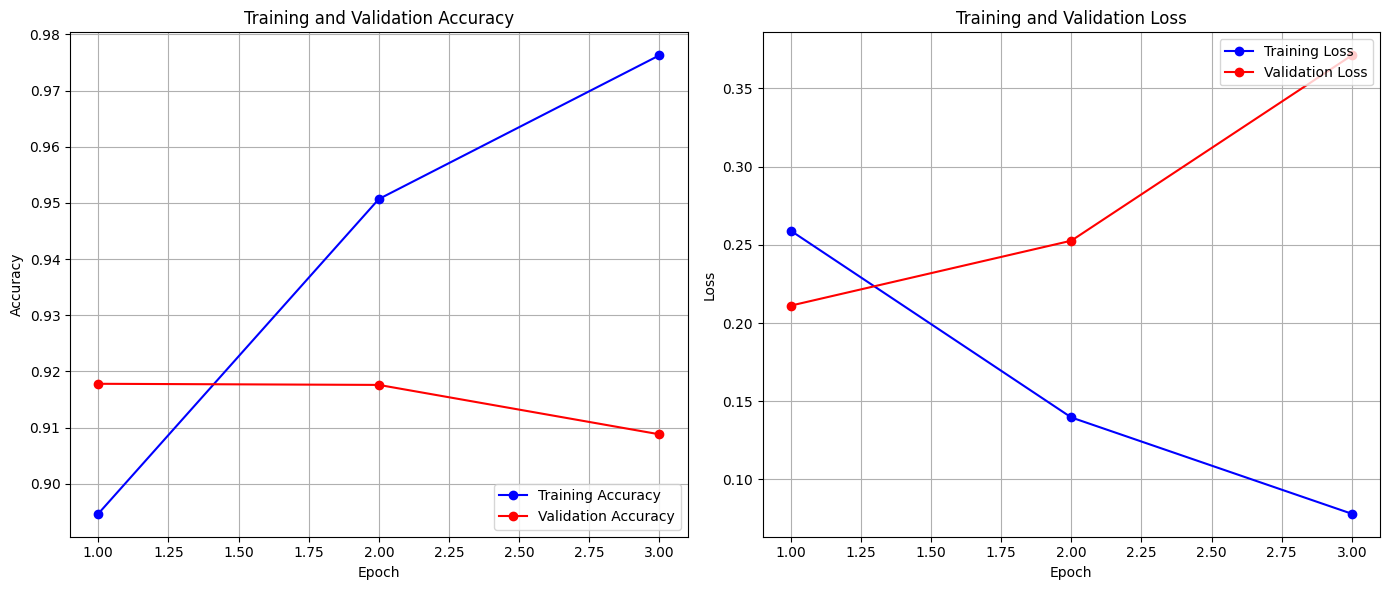


--- Evaluation ---
Evaluating model on the test set using model.evaluate....
1563/1563 [==============================] - 263s 167ms/step

Confusion Matrix:
[[11982   518]
 [ 1624 10876]]


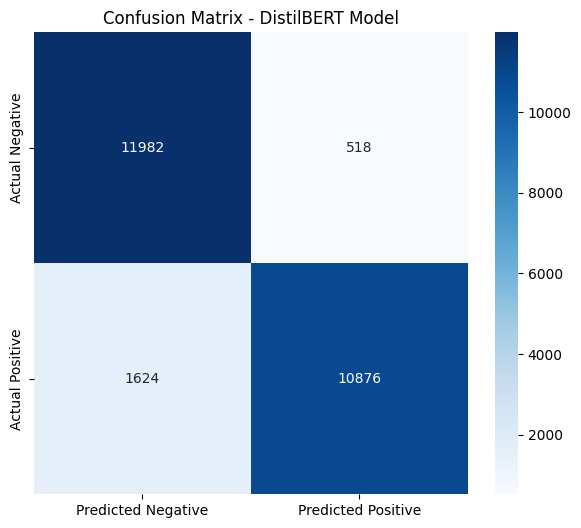


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.96      0.92     12500
    Positive       0.95      0.87      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.92      0.91      0.91     25000
weighted avg       0.92      0.91      0.91     25000


Metrics calculated using compute_metrics function (if available):
Accuracy: 0.9143
Precision: 0.9545
Recall: 0.8701
F1 Score: 0.9104


In [18]:
# --- Configuration ---
MODEL_CHECKPOINT = "distilbert-base-uncased" # Pre-trained model identifier from Hugging Face
MAX_LENGTH = 500
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5


# --- Preprocessing (Tokenization) ---
# Load the tokenizer associated with the model
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
print(f"Tokenizer loaded for {MODEL_CHECKPOINT}")


# Define the function to tokenize the text
def tokenize_function(examples):
    cleaned_texts = [re.sub(r'<.*?>', ' ', text) for text in examples['text']]
    return tokenizer(cleaned_texts, truncation=True, max_length=MAX_LENGTH, padding=False)

print("Tokenizing dataset (this may take a few minutes)...")
# Apply tokenization to all splits (train, test) using .map()
tokenized_datasets = imdb_dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format to TensorFlow tensors, required for TFAutoModel and model.fit
tokenized_datasets.set_format("tensorflow")



# --- Data Splitting ---
train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=SEED, stratify_by_column="labels")

# Create a new DatasetDict
processed_datasets = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': tokenized_datasets['test']
})

print("Dataset splits prepared:")
print(processed_datasets)

# --- Load Pre-trained Model ---

# Load the pre-trained DistilBERT model configured for sequence classification using TF weights
model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2
)
print(f"TF Model loaded for {MODEL_CHECKPOINT}")
model.config.id2label = {0: "Negative", 1: "Positive"}
model.config.label2id = {"Negative": 0, "Positive": 1}


# --- Fine-tuning Setup ---

# Data Collator: Handles dynamic padding within each batch.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# --- Define Metrics Computation ---
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    # The model outputs logits (raw scores). We need to convert these to predicted class IDs
    # Check if predictions are within a TF output object or just the logits tensor
    if hasattr(predictions, 'logits'):
        logits = predictions.logits
    elif isinstance(predictions, (list, tuple)):
        logits = predictions[0]
    else:
        logits = predictions

    # Get the index of the highest logit for each sample -> predicted class
    preds = np.argmax(logits, axis=1)

    # Compute metrics using the loaded evaluate modules
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average="binary")
    recall = recall_metric.compute(predictions=preds, references=labels, average="binary")
    f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")

    # Return metrics as a dictionary
    return {
        "accuracy": acc["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

# --- Compile the Model for model.fit ---
# Since we're using TensorFlow's `model.fit`, we need to compile the model
# with an optimizer, loss function, and any Keras metrics we want to track during training.

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics_list = ['accuracy']


model.compile(optimizer='adam', loss=loss_fn, metrics=metrics_list)
tf.keras.backend.set_value(model.optimizer.learning_rate, LEARNING_RATE)


# --- Fine-tuning ---

# Prepare datasets for model.fit using .to_tf_dataset()
tf_train_dataset = processed_datasets['train'].to_tf_dataset(
    columns=[col for col in processed_datasets['train'].column_names if col not in ['labels', 'idx']],
    label_cols="labels",
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

tf_validation_dataset = processed_datasets['validation'].to_tf_dataset(
    columns=[col for col in processed_datasets['validation'].column_names if col not in ['labels', 'idx']],
    label_cols="labels",
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

print(f"Starting fine-tuning using model.fit for {NUM_EPOCHS} epochs...")

# Use model.fit for training
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=NUM_EPOCHS,
)

print("Fine-tuning finito.")

# Plot training history
plot_training_history(history)


# --- Evaluation ---
print("\n--- Evaluation ---")

# Evaluate the fine-tuned model on the test set.
print("Evaluating model on the test set using model.evaluate....")

# Prepare the test dataset for evaluation
tf_test_dataset = processed_datasets['test'].to_tf_dataset(
    columns=[col for col in processed_datasets['test'].column_names if col not in ['labels', 'idx']],
    label_cols="labels",
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

eval_results = model.evaluate(tf_test_dataset, verbose=1)

print("\nTest Set Evaluation Results (from model.evaluate):")
print(f"Test Loss: {eval_results[0]:.4f}")
print(f"Test Accuracy: {eval_results[1]:.4f}")


# --- Analyzing DistilBERT Results ---
print("\n--- Analyzing DistilBERT Results ---")

# To get the confusion matrix and classification report, we need predictions on the test set.
print("Generating predictions on the test set for detailed analysis...")
test_predictions = model.predict(tf_test_dataset)

# Extract the logits array from the prediction output object
# The structure might vary; TF models often return a dict-like object.
# Check for common attributes like 'logits'.
if hasattr(test_predictions, 'logits'):
    logits = test_predictions.logits
elif isinstance(test_predictions, dict) and 'logits' in test_predictions:
     logits = test_predictions['logits']
elif isinstance(test_predictions, (list, tuple)):
     logits = test_predictions[0]
else:
     # Fallback assuming the direct output are logits
     print("Warning: Could not directly find 'logits'. Assuming predict output is the logits array.")
     logits = test_predictions

# Convert logits to predicted labels (0 or 1) by taking the argmax
predicted_labels = np.argmax(logits, axis=1)
# Get the true labels from the original dataset
true_labels = processed_datasets['test']['labels']

if not isinstance(true_labels, np.ndarray):
    true_labels = np.array(true_labels)

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - DistilBERT Model')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))

# Use the compute_metrics function for consistency
print("\nMetrics calculated using compute_metrics function (if available):")
metrics = compute_metrics((logits, true_labels))
if metrics:
    print(f"Accuracy: {metrics.get('accuracy', 'N/A'):.4f}")
    print(f"Precision: {metrics.get('precision', 'N/A'):.4f}")
    print(f"Recall: {metrics.get('recall', 'N/A'):.4f}")
    print(f"F1 Score: {metrics.get('f1', 'N/A'):.4f}")

## Analyzing DistilBERT Results

Based on the output from running the DistilBERT fine-tuning and evaluation in your notebook:

* **Evaluation:** The fine-tuned DistilBERT model achieved a Test Accuracy of **91.43%**. Other key metrics calculated were:
    * Precision: 0.9545
    * Recall: 0.8701
    * F1 Score: 0.9104
* **Analysis:**
    * The confusion matrix shows the model performed well, correctly identifying 11982 negative reviews and 10876 positive reviews. It incorrectly classified 518 negative reviews as positive (False Positives) and 1624 positive reviews as negative (False Negatives).
    * The classification report indicates high performance, particularly noting high precision (0.95) for positive predictions and high recall (0.96) for negative predictions.


## Model Comparison

Here's a summary comparing the performance of the two models on the test set:

| Model        | Test Accuracy | Test Loss | Metrics (Weighted Avg F1) | Notes                                             |
| :----------- | :-----------: | :-------: | :---------------------------: | :------------------------------------------------ |
| **1D CNN** |    88.58%     |  0.2775   |             0.89              | Good baseline, fast training, needed Early Stopping |
| **DistilBERT** |    91.43%     |  0.3712 |             0.91              | Better accuracy, longer training time             |


The comparison clearly shows that fine-tuning the pre-trained DistilBERT model led to an improvement in accuracy and F1-score compared to the 1D CNN trained from scratch.

## Conclusion

And that's a it! We went through the whole process:

1.  Loaded and explored the IMDB dataset, cleaning the text and understanding its characteristics like review length and common words.
2.  Built and trained a baseline 1D CNN model, achieving a respectable accuracy of approximately 88.6%. Early stopping was crucial to prevent overfitting.
3.  Fine-tuned a powerful pre-trained DistilBERT model on our dataset, which further improved the accuracy to approximately 91.4%.

By comparing the results, we can see the improvement the more advanced Transformer model (DistilBERT) offered over the simpler CNN baseline (~2.8% increase in accuracy).
